In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
#!wget --no-check-certificate \
#    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
#    -O /tmp/daily-min-temperatures.csv

In [6]:
root = r'D:\Users\Arkady\Verint\Coursera_2019_Tensorflow_Specialization\Course4_Sequences_TimeSeries_Prediction'
srcurl = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
#https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

In [7]:
import pandas as pd

df = pd.read_csv(srcurl)
df.to_csv(root + '/tmp/daily-min-temperatures.csv')

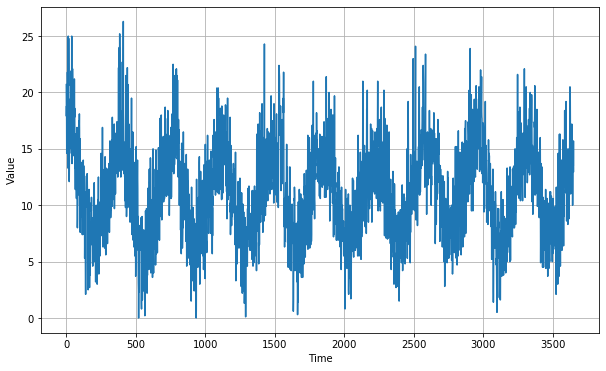

In [8]:
import csv
time_step = []
temps = []

with open(root + '/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    temps.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [18]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [19]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [20]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 7s 717ms/step - loss: 31.1549 - mae: 31.6551
Epoch 2/100
10/10 [==============================] - 2s 237ms/step - loss: 30.5753 - mae: 31.0783
Epoch 3/100
10/10 [==============================] - 2s 230ms/step - loss: 29.7469 - mae: 30.1792
Epoch 4/100
10/10 [==============================] - 2s 232ms/step - loss: 28.5816 - mae: 29.0582
Epoch 5/100
10/10 [==============================] - 2s 228ms/step - loss: 27.1349 - mae: 27.6970
Epoch 6/100
10/10 [==============================] - 2s 228ms/step - loss: 25.5287 - mae: 25.9975
Epoch 7/100
10/10 [==============================] - 2s 221ms/step - loss: 23.3412 - mae: 23.8407
Epoch 8/100
10/10 [==============================] - 2s 221ms/step - loss: 20.6980 - mae: 21.1120
Epoch 9/100
10/10 [==============================] - 2s 224ms/step - loss: 17.4437 - mae: 17.8083
Epoch 10/100
10/

[1e-08, 0.0001, 0, 60]

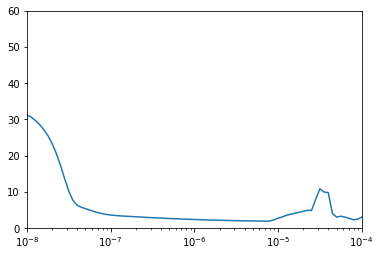

In [22]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [29]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)

])


optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 6s 253ms/step - loss: 12.5038 - mae: 13.1784
Epoch 2/150
25/25 [==============================] - 3s 117ms/step - loss: 2.7730 - mae: 3.2301
Epoch 3/150
25/25 [==============================] - 3s 117ms/step - loss: 2.0288 - mae: 2.4839
Epoch 4/150
25/25 [==============================] - 3s 116ms/step - loss: 1.9004 - mae: 2.3558
Epoch 5/150
25/25 [==============================] - 3s 114ms/step - loss: 1.8576 - mae: 2.3103
Epoch 6/150
25/25 [==============================] - 3s 115ms/step - loss: 1.8274 - mae: 2.2795
Epoch 7/150
25/25 [==============================] - 3s 114ms/step - loss: 1.8062 - mae: 2.2571
Epoch 8/150
25/25 [==============================] - 3s 115ms/step - loss: 1.7796 - mae: 2.2288
Epoch 9/150
25/25 [==============================] - 3s 113ms/step - loss: 1.7616 - mae: 2.2097
Epoch 10/150
25/25 [==============================] - 3s 116ms/step - loss: 1.7408 - mae: 2.1888
Epoch 11/150
25/25 [=================

In [30]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

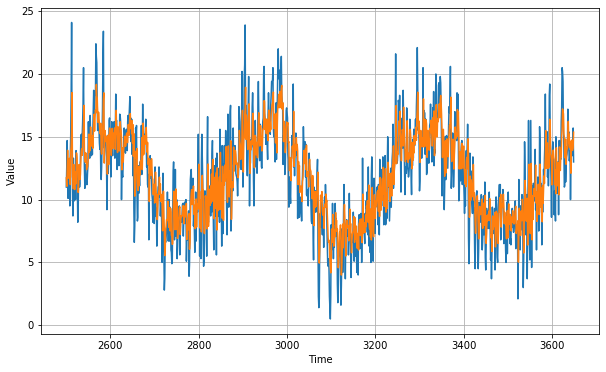

In [31]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [32]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7951926

In [33]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.730679  11.0490265 12.450037  ... 13.932469  14.106003  15.365514 ]
